In [1]:
!pip install efficientnet_pytorch
from tqdm.notebook import tqdm
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
import torch.optim as optim

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.1-cp36-none-any.whl size=12407 sha256=705d7678c8f966ca7ca3a8eca31edd61c1065b1a501d087805d750d1d3fb107f
  Stored in directory: /root/.cache/pip/wheels/0f/b0/79/1663bc9714b5d88deba05e44f593ce50111bd69305a45df87a
Successfully built efficientnet-pytorch


In [2]:
def linear(ni, no, act=nn.ReLU()): return nn.Sequential(nn.Linear(ni,no),act)

In [3]:
class nop(nn.Module):
    def __init__(self): super().__init__()
    def forward(self,x): return x

class Efficient_AutoEncoder(nn.Module):
    def __init__(self, nh, version = "efficientnet-b0", advprop = False, use_pool=False):
        super().__init__()
        self.conv = EfficientNet.from_pretrained(version, advprop=advprop)
        self.pool = nn.AdaptiveMaxPool2d(1) if use_pool else nop()
        self.encoder = nn.Sequential(linear(nh,1024),
                                     linear(1024,512),
                                     linear(512, 256),
                                     linear(256, 64))
        self.decoder = nn.Sequential(linear(64, 256),
                                     linear(256,512),
                                     linear(512,nh))
        self.training_losses, self.validation_losses = [], []
        
    def forward(self, x):
        fm = torch.flatten(self.pool(self.conv.extract_features(x)), start_dim=1)
        enc = self.encoder(fm)
        return enc

    def get_feature_map(self, x):
        with torch.no_grad():
            fm= self.conv.extract_features(x)
        return fm

    def _forward(self, x):
        fm = self.get_feature_map(x)
        enc = self.encoder(torch.flatten(self.pool(fm), start_dim=1))
        dec = self.decoder(enc)
        return torch.sigmoid(dec)

    def fit_encoder(self, tdl, vdl=None, num_epochs=1, lr = 1e-6):
        pb = tqdm(range(num_epochs))
        optimizer = optim.Adam([*self.encoder.parameters(), *self.decoder.parameters()], lr=lr)
        criterion = nn.BCELoss()
        for e in pb:
            self.train()
            for x, _ in tdl:
                x = x.cuda()
                optimizer.zero_grad()
                y = torch.flatten(self.get_feature_map(x), start_dim=1)
                yhat = self._forward(x)
                loss = criterion(yhat,y)
                loss.backward()
                optimizer.step()
                pb.set_description(f"Loss: {loss.item()}")
                self.training_losses.append(loss.item())
            self.evaluate(vdl)
            
    def evaluate(self, dl):
        criterion = nn.BCELoss()
        self.eval()
        with torch.no_grad():
            for x, y in dl:
                x,y = x.cuda(), y.cuda()
                y = self.get_feature_map(x)
                yhat = self._forward(x)
                loss = criterion(yhat,y)
                self.validation_losses.append(loss.item())


In [4]:
nh = 1280*4*4 # for (version = b0, use_pool=False)
model = Efficient_AutoEncoder(1280*4*4).cuda()

Downloading: "https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [5]:
from torchvision.datasets import CIFAR10 as load_data
import torchvision.transforms as transforms
convert = transforms.Compose([transforms.Pad((128-32)//2),transforms.ToTensor()])
path = load_data(root='../working', train=True, download=True, transform=convert)
tdl = torch.utils.data.DataLoader(path, batch_size=128, shuffle=True)
path = load_data(root='../working', train=False, download=True, transform=convert)
vdl = torch.utils.data.DataLoader(path, batch_size=128, shuffle=True)

Extracting ../working/cifar-10-python.tar.gz to ../working
Files already downloaded and verified


In [6]:
model.fit_encoder(tdl, vdl, num_epochs=10, lr=1e-3)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128, 1280, 4, 4])) that is different to the input size (torch.Size([128, 20480])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16, 1280, 4, 4])) that is different to the input size (torch.Size([16, 20480])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


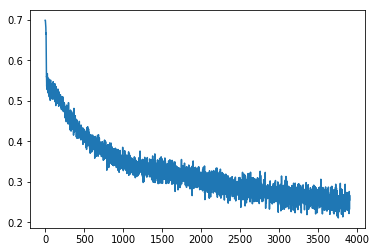

In [7]:
import matplotlib.pyplot as plt

plt.plot(model.training_losses)

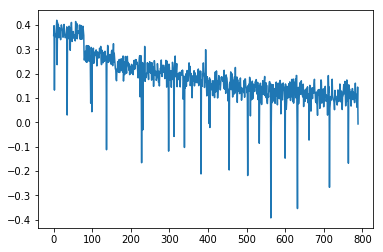

In [8]:
plt.plot(model.validation_losses)

In [9]:
import pickle

with open("../working/model.pkl", 'wb') as f:
    pickle.dump(model,f)